In [1]:
import os, sys, joblib, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams["figure.figsize"] = (8,5)

In [6]:
required = [
    "../results/model_results.joblib"
    "../data/processed/final_model_input.pkl", "../models/best_model_XGBoost_tuned.joblib"
]

In [8]:
print("Loading results/model_results.joblib ...")
bundle = joblib.load("../results/model_results.joblib")

# bundle expected keys: {"metrics": {...}, "y_test": np.array, "y_pred": np.array}
metrics_logged = bundle.get("metrics", {})
y_test = bundle.get("y_test", None)
y_pred_log = bundle.get("y_pred", None)

if y_test is None or y_pred_log is None:
    raise ValueError("model_results.joblib missing y_test or y_pred. Re-create results via modeling notebook.")

model_name = metrics_logged.get("model", "UNKNOWN")
print("Best model (logged):", model_name)
print("Logged metrics (log-space):", metrics_logged)

Loading results/model_results.joblib ...
Best model (logged): XGBoost_tuned
Logged metrics (log-space): {'model': 'XGBoost_tuned', 'rmse': 1.365377685333351, 'mae': 0.4712433509534344, 'r2': 0.38352085030338934}


In [10]:
if os.path.exists("../data/processed/final_model_input.pkl"):
    try:
        fi = joblib.load("../data/processed/final_model_input.pkl")
        X_all = fi.get("X", None)
        print("Loaded X (final feature matrix) shape:", None if X_all is None else X_all.shape)
    except Exception as e:
        print("Could not load data/processed/final_model_input.pkl:", e)
else:
    print("Note: data/processed/final_model_input.pkl not found (optional). Continue anyway.")


Loaded X (final feature matrix) shape: (1000, 2048)


In [11]:
# y_test and y_pred_log are in log space (log(1+price))
y_test_price = np.expm1(y_test.astype(float))
y_pred_price = np.expm1(y_pred_log.astype(float))

# handle potential NaNs or infs
finite_mask = np.isfinite(y_test_price) & np.isfinite(y_pred_price)

# compute standard metrics (in log-space and price-space)
def safe_rmse(a,b):
    return math.sqrt(mean_squared_error(a,b))

rmse_log = metrics_logged.get("rmse", float("nan"))
mae_log = metrics_logged.get("mae", float("nan"))
r2_log = metrics_logged.get("r2", float("nan"))

rmse_price = safe_rmse(y_test_price[finite_mask], y_pred_price[finite_mask])
mae_price = mean_absolute_error(y_test_price[finite_mask], y_pred_price[finite_mask])

# compute MAPE carefully — avoid division by zero
nonzero_mask = finite_mask & (y_test_price != 0)
if nonzero_mask.sum() == 0:
    mape_price = float("nan")
else:
    mape_price = np.mean(np.abs((y_test_price[nonzero_mask] - y_pred_price[nonzero_mask]) / y_test_price[nonzero_mask])) * 100

print("\nEvaluation (converted to price units):")
print(f"  RMSE (price): {rmse_price:.2f}")
print(f"  MAE  (price): {mae_price:.2f}")
print(f"  MAPE (price, %): {mape_price if not math.isinf(mape_price) else float('nan')}")


Evaluation (converted to price units):
  RMSE (price): 8471868.21
  MAE  (price): 3898674.93
  MAPE (price, %): 28.813154558318676


In [12]:
os.makedirs("../results/figures", exist_ok=True)

final_metrics = {
    "model": model_name,
    "rmse_log": rmse_log,
    "mae_log": mae_log,
    "r2_log": r2_log,
    "rmse_price": rmse_price,
    "mae_price": mae_price,
    "mape_price": mape_price
}
joblib.dump(final_metrics, "../results/final_metrics_for_report.joblib")
print("Saved final metrics → results/final_metrics_for_report.joblib")

Saved final metrics → results/final_metrics_for_report.joblib


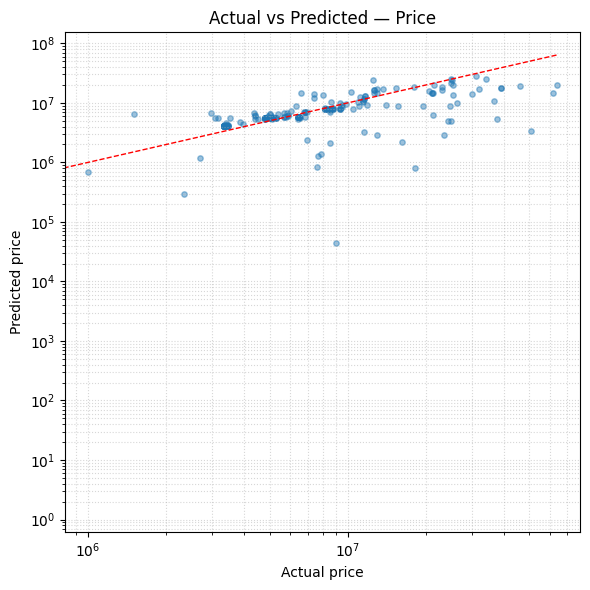

In [13]:
# A) Actual vs Predicted (price)
plt.figure(figsize=(6,6))
plt.scatter(y_test_price, y_pred_price, alpha=0.45, s=15)
mx = max(np.nanmax(y_test_price), np.nanmax(y_pred_price))
plt.plot([0, mx], [0, mx], 'r--', linewidth=1)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs Predicted — Price")
plt.xscale('log')  # optional: log scale to show wide ranges
plt.yscale('log')
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.savefig("../results/figures/actual_vs_predicted_price.png", dpi=150)
plt.show()

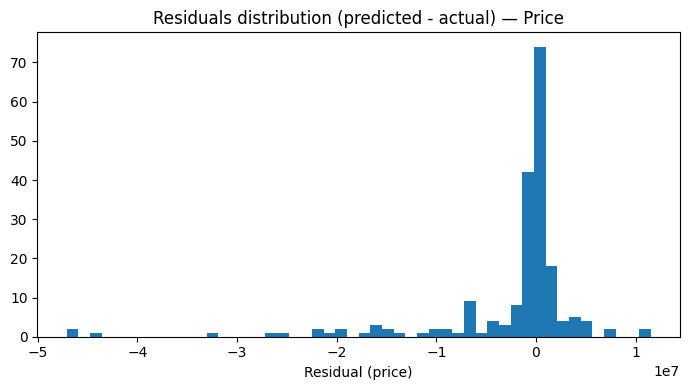

In [15]:
# B) Residuals histogram (price)
residuals_price = y_pred_price - y_test_price
plt.figure(figsize=(7,4))
plt.hist(residuals_price[finite_mask], bins=50)
plt.title("Residuals distribution (predicted - actual) — Price")
plt.xlabel("Residual (price)")
plt.tight_layout()
plt.savefig("../results/figures/residuals_price_hist.png", dpi=150)
plt.show()

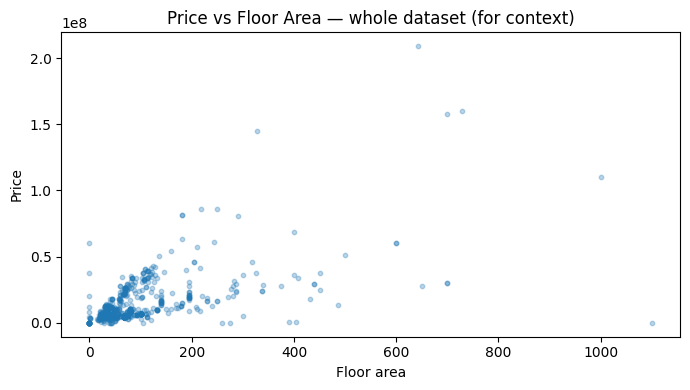

In [16]:
# C) Scatter: error vs floor_area (if floor_area exists in processed dataset)
if os.path.exists("../data/processed/feature_engineered_dataset.csv"):
    try:
        df_proc = pd.read_csv("../data/processed/feature_engineered_dataset.csv")
        # try to align test indices — we don't have direct indices, but we can show a general plot
        if "floor_area" in df_proc.columns:
            plt.figure(figsize=(7,4))
            plt.scatter(df_proc["floor_area"], df_proc["price"], alpha=0.3, s=10)
            plt.xlabel("Floor area")
            plt.ylabel("Price")
            plt.title("Price vs Floor Area — whole dataset (for context)")
            plt.tight_layout()
            plt.savefig("../results/figures/price_vs_floor_area.png", dpi=150)
            plt.show()
    except Exception as e:
        print("Could not load feature_engineered_dataset.csv for additional plots:", e)

In [18]:
# 6. TOP / WORST PREDICTIONS — example table for the report
df_preds = pd.DataFrame({
    "actual_price": y_test_price,
    "predicted_price": y_pred_price,
    "error_abs": np.abs(residuals_price),
    "error_rel_pct": np.where(y_test_price!=0, np.abs(residuals_price) / (y_test_price + 1e-9) * 100.0, np.nan)
})

df_preds_sorted = df_preds.sort_values("error_abs", ascending=False).reset_index(drop=True)
df_preds_top10 = df_preds_sorted.head(10)
df_preds_top10.to_csv("../results/top10_worst_predictions.csv", index=False)
print("Saved top-10 worst predictions → results/top10_worst_predictions.csv")
df_preds_top10.head(10)

# Save the full predictions CSV
df_preds.to_csv("../results/final_predictions_full.csv", index=False)
print("Saved full predictions → results/final_predictions_full.csv")

Saved top-10 worst predictions → results/top10_worst_predictions.csv
Saved full predictions → results/final_predictions_full.csv


In [21]:
summary_text = f"""
FINAL MODEL REPORT
==================

Project: Housing Rental Price Estimator — multimodal (text + interior images)

Best Model (chosen): {model_name}

Log-space performance (model reported values):
- RMSE (log): {rmse_log:.4f}
- MAE  (log): {mae_log:.4f}
- R²   (log): {r2_log:.4f}

Real-price performance (converted from log-space):
- RMSE (price): {rmse_price:.2f}
- MAE  (price): {mae_price:.2f}
- MAPE (price): {"N/A (division by zero present)" if (math.isnan(mape_price) or math.isinf(mape_price)) else f\"{mape_price:.2f}%\"}

Notes on MAPE:
- MAPE is undefined when any true price equals 0. The dataset contains such listings (or extremely small values),
  so MAPE is not a reliable metric here. We therefore prefer RMSE/MAE and log-space metrics for evaluation.

Interpretation:
- The log-space RMSE and R² are the most meaningful indicators in this setting; R² ~ {r2_log:.2f} indicates moderate explanatory power.
- In real-price units the MAE (= {mae_price:.2f}) indicates the average absolute error per listing.

Artifacts produced by this notebook:
- results/final_predictions_full.csv
- results/top10_worst_predictions.csv
- results/final_metrics_for_report.joblib
- results/final_metrics_for_report.joblib (pickled metrics)
- results/figures/*.png

Suggested next improvements (if extra time permits):
1. Replace MiniLM with a larger text encoder (e.g., MPNet) for better text embeddings.
2. Replace EfficientNet-B0 with ViT or ConvNeXt for stronger image embeddings.
3. Train an end-to-end multimodal neural network and/or perform stacked ensembling.
4. Remove or fix entries with price==0 in data preprocessing.

"""

with open("../results/final_report_extended.txt", "w") as f:
    f.write(summary_text)

print("Saved textual report → results/final_report_extended.txt")
print("\n--- SHORT SUMMARY ---\n")
print(summary_text.splitlines()[:20])  # print first lines for quick check

SyntaxError: f-string expression part cannot include a backslash (3533134201.py, line 40)